In [108]:
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from getpass import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
import os.path
from scipy import stats
import requests
from astroquery.simbad import Simbad
from astropy import coordinates
from astropy.coordinates import search_around_3d
from astropy.table import QTable, Table, Column
from astropy import constants as const

In [1]:
# Description: This code determines an appropriate range of redshift for the query 
# It tries different values of redshift given by cz = 4000000, 6000000, 10000000, 12000000, and 14000000 as an upper limit 
# and determines which value gives the steepest plot of mean density 

In [228]:
t = pd.read_csv('result_Simbad_edited.csv')
print(type(t))
z = t['Z_VALUE']
c = const.c
v0, v1, v2, v3, v4 = 4000000, 6000000, 10000000, 12000000, 14000000

<class 'pandas.core.frame.DataFrame'>


In [229]:
lower_z = v0/c
z1 = v1/c
z2 = v2/c
z3 = v3/c
z4 = v4/c

In [230]:
z1, z2, z3, z4

(<Quantity 0.02001385 s / m>,
 <Quantity 0.03335641 s / m>,
 <Quantity 0.04002769 s / m>,
 <Quantity 0.04669897 s / m>)

In [218]:
upper_z = z1 # Try z1 ~ z4

In [219]:
df = t[(t['Z_VALUE']<upper_z) & (t['Z_VALUE']>lower_z)]

In [220]:
sep_all = df['separation']

In [221]:
sep_red, sep_blue = np.array([]), np.array([])
color = np.array(df['color'])
for i in range(len(df)):
    if color[i] < 0.45:
        #print('blue')
        sep_blue = np.append(sep_blue, np.array(df['separation'])[i])
    elif color[i] < 0.9:
        #print('red')
        sep_red = np.append(sep_red, np.array(df['separation'])[i])

array([0.05      , 0.062353  , 0.07775793, 0.0969688 , 0.1209259 ,
       0.15080185, 0.18805895, 0.23452079, 0.29246148, 0.36471701,
       0.45482397, 0.56719276, 0.70732338, 0.88207467, 1.1       ])

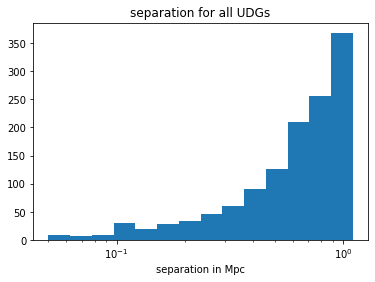

In [222]:
fig, ax = plt.subplots()
# bins_list is used to adjust the number of bins in linear scale
#bins_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]

# set do_log = 0 for linear bins, = 1 for log bins
do_log = 1

ax.set(title='separation for all UDGs', xlabel='separation in Mpc')

if do_log == 1:
    hist_UDGs = plt.hist(sep_all, bins=np.logspace(start=np.log10(0.05), stop=np.log10(1.1), num=15),density=False)
    plt.gca().set_xscale("log")
else:
    hist_UDGs = plt.hist(sep_all, bins=15)
    plt.gca().set_xscale('log') # changes the scale to log

plt.show
#plt.legend;
len(hist_UDGs[0])
hist_UDGs[1] # edges of each bin (=x values), which later will be used as radius 

<function matplotlib.pyplot.show(*args, **kw)>

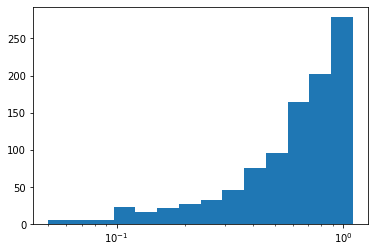

In [223]:
# Creates the histogram of red UDGs
#redhist = plt.hist(red, bins=15)#bins_list)
#plt.gca().set_xscale('log')

ax.set(title='separation for red UDGs', xlabel='separation in Mpc')

if do_log == 1:
#    redhist = plt.hist(red, bins=np.logspace(start=np.log10(0.05), stop=np.log10(1.1), num=15),density=False)
    redhist = plt.hist(sep_red, bins=hist_UDGs[1])
    plt.gca().set_xscale("log")
    plt.gca().set_xscale("log")
else:
    redhist = plt.hist(sep_red, bins=15)
    plt.gca().set_xscale('log') # changes the scale to log

plt.show

#redhist[0]

<bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x7f240a799110>>

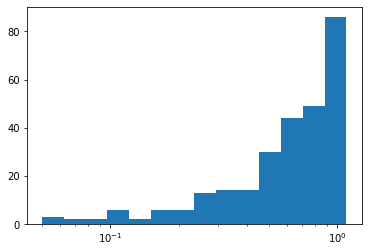

In [224]:
# Creates the histogram of blue UDGs
#bluehist = plt.hist(blue, bins=15)#bins_list)
#plt.gca().set_xscale('log')

ax.set(title='separation for blue UDGs', xlabel='separation in Mpc')

if do_log == 1:
#    bluehist = plt.hist(blue, bins=np.logspace(start=np.log10(0.05), stop=np.log10(1.1), num=15),density=False)
    bluehist = plt.hist(sep_blue, bins=hist_UDGs[1])
    plt.gca().set_xscale("log")
    
else:
    bluehist = plt.hist(sep_blue, bins=15)
    plt.gca().set_xscale('log') # changes the scale to log

#plt.show
ax.legend

In [225]:
# Below is used to calculate areas of annuli 
# Skip to the next cell for log scaling
area_annulus = np.array([])
# Calculates the area of annulus (= pi*(R^2-r^2))
a = np.array([])

# NEW
for i in range(0, 14):
    R = hist_UDGs[1][i+1] # R = outer radius
    r = hist_UDGs[1][i] # r = inner radius 
    # calculate area of annulus and convert to kpc^2
    area = np.pi*(R**2 - r**2)*(1000*1000)
    area_annulus = np.append(area_annulus, area)
    a = np.append(a, (hist_UDGs[1][i] + hist_UDGs[1][i+1])/2.)
       
print(area_annulus)

[   4360.20495168    6780.80995265   10545.23448403   16399.51143002
   25503.84019914   39662.51480595   61681.49848998   95924.50893706
  149177.81895831  231995.15864877  360789.25146042  561084.48438117
  872575.32573091 1356992.96677958]


In [226]:
#hist_UDGs = hist_UDGs[0]
#redhist = redhist[0]
#bluehist = bluehist[0]
UDGs_hist = np.array([])
density_red = np.array([])
density_blue = np.array([])
for i in range(0,14):
    density_UDGs = hist_UDGs[0][i]/area_annulus[i]
    density_r = redhist[0][i]/area_annulus[i]
    density_b = bluehist[0][i]/area_annulus[i]
    UDGs_hist = np.append(UDGs_hist, density_UDGs)
    density_red = np.append(density_red, density_r)
    density_blue = np.append(density_blue, density_b)
print(density_red)

[0.00114674 0.00073738 0.00056898 0.00140248 0.00062736 0.00055468
 0.00043773 0.00034402 0.00030836 0.00032759 0.00026331 0.00029229
 0.0002315  0.0002056 ]


coefficients for all UDGs are:  [-0.6129587  -6.93861788]
coefficients for red UDGs are:  [-0.57776614 -7.03544859]
coefficients for blue UDGs are:  [-0.69658072 -7.6567665 ]


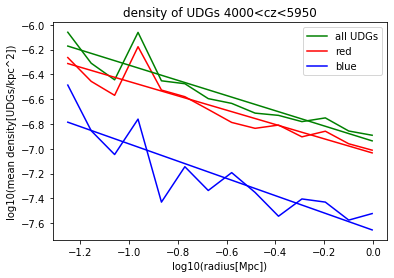

In [227]:
plt.title('density of UDGs 4000<cz<5950')
plt.xlabel('log10(radius[Mpc])')
plt.ylabel('log10(mean density[UDGs/kpc^2])')
if do_log == 1:
    x_prime = np.log10(a)
else:
    x_prime = a
y_prime = np.log10(UDGs_hist/len(sep_all))
y_r = np.log10(density_red/len(sep_all))
y_b = np.log10(density_blue/len(sep_all))
plt.plot(x_prime, y_prime, label='all UDGs', color='g')
plt.plot(x_prime, y_r, label='red', color='red')
plt.plot(x_prime, y_b, label='blue', color='blue')

coeff = np.polyfit(x_prime, y_prime, 1) # m=slopes & b = y-intercept
Y = np.polyval(coeff, x_prime)
plt.plot(x_prime,Y,color='g')
print('coefficients for all UDGs are: ', coeff)

coeff = np.polyfit(x_prime, y_r, 1) # m=slopes & b = y-intercept
Y = np.polyval(coeff, x_prime)
plt.plot(x_prime,Y,color='r')
print('coefficients for red UDGs are: ', coeff)

coeff = np.polyfit(x_prime, y_b, 1) # m=slopes & b = y-intercept
Y = np.polyval(coeff, x_prime)
plt.plot(x_prime,Y,color='b')
print('coefficients for blue UDGs are: ', coeff)

plt.legend()
#plt.plot(x_prime, m*x_prime + b)

In [107]:
lower_z

<Quantity 0.01334256 s / m>